In [1]:
import torch
print("GPU Available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

GPU Available: True
Device: NVIDIA GeForce RTX 3070 Ti Laptop GPU


In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud

In [3]:
train_data = pd.read_csv("../Dataset/train_data.csv")
val_data = pd.read_csv("../Dataset/val_data.csv")
test_data = pd.read_csv("../Dataset/test_data.csv")

In [4]:
def combine_text(row):
    return row["title"] + " " + row["text"]

In [5]:
train_data["content"] = train_data.apply(combine_text, axis=1)
val_data["content"] = val_data.apply(combine_text, axis=1)
test_data["content"] = test_data.apply(combine_text, axis=1)

In [6]:
encoder = LabelEncoder()
train_data["label"] = encoder.fit_transform(train_data["label"])
val_data["label"] = encoder.transform(val_data["label"])

In [7]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [8]:
def tokenize_data(data, tokenizer, max_len=512):
    return tokenizer(
        data["content"].tolist(),
        padding="max_length",
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )

train_encodings = tokenize_data(train_data, tokenizer)
val_encodings = tokenize_data(val_data, tokenizer)
test_encodings = tokenize_data(test_data, tokenizer)

In [9]:
class FakeNewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
        }

train_dataset = FakeNewsDataset(train_encodings, train_data["label"].tolist())
val_dataset = FakeNewsDataset(val_encodings, val_data["label"].tolist())
test_dataset = FakeNewsDataset(test_encodings, test_data["label"].tolist())

In [10]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [11]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=len(train_data["label"].unique())
)
model.to("cuda" if torch.cuda.is_available() else "cpu")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [12]:
optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

c:\Users\stoic\miniconda3\envs\llms_env\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [13]:
def train_model(model, train_loader, val_loader, optimizer, scheduler, epochs=1):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    loss_fn = CrossEntropyLoss()
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in tqdm(train_loader):
            optimizer.zero_grad()

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels,
            )
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch + 1}, Training Loss: {avg_loss}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                )
                predictions = torch.argmax(outputs.logits, dim=1)
                correct += (predictions == labels).sum().item()
                total += labels.size(0)

        accuracy = correct / total
        val_accuracies.append(accuracy * 100)
        print(f"Validation Accuracy: {accuracy * 100:.2f}%")
        scheduler.step()

    return train_losses, val_accuracies

In [14]:
train_losses, val_accuracies = train_model(model, train_loader, val_loader, optimizer, scheduler)

100%|██████████| 2214/2214 [33:55<00:00,  1.09it/s]


Epoch 1, Training Loss: 0.017794586610113
Validation Accuracy: 99.98%


In [17]:
# Plot Training and Validation
def plot_training_progress(train_losses, val_accuracies):
    epochs = 1
    
    fig, ax1 = plt.subplots()
    
    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(range(epochs), train_losses, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Validation Accuracy', color=color)
    ax2.plot(range(epochs), val_accuracies, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    fig.tight_layout()
    plt.show()

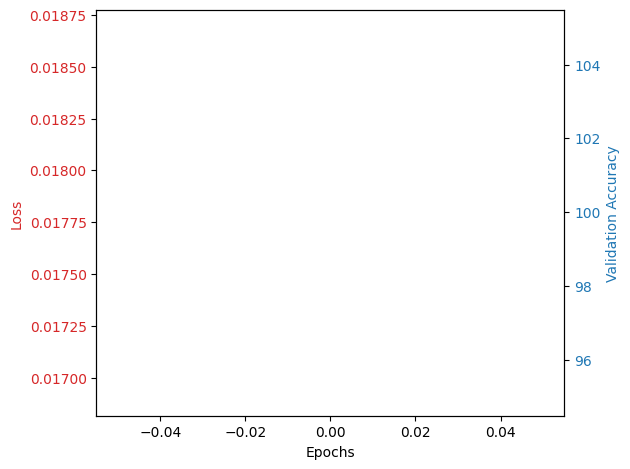

In [18]:
plot_training_progress(train_losses, val_accuracies)

In [19]:
# Evaluate Model
model.eval()
def evaluate_model_on_test(model, test_loader):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels

In [20]:
predictions, true_labels = evaluate_model_on_test(model, test_loader)

100%|██████████| 277/277 [01:17<00:00,  3.59it/s]


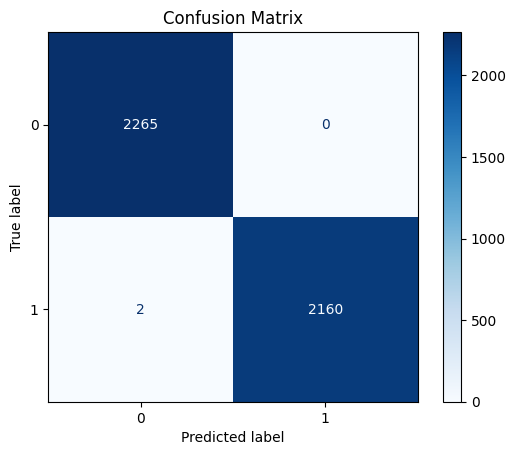

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay
# Confusion Matrix
class_names = encoder.classes_
def plot_confusion_matrix(true_labels, predictions, class_names):
    cm = confusion_matrix(true_labels, predictions, labels=range(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(true_labels, predictions, class_names)

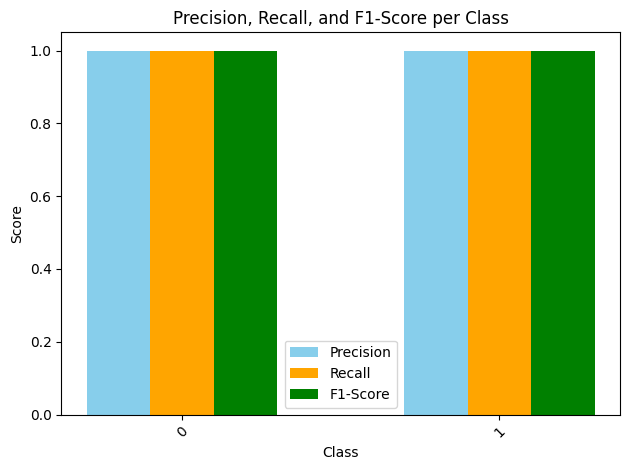

In [23]:
# Precision, Recall, F1
def plot_precision_recall_f1(true_labels, predictions, class_names):
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, labels=range(len(class_names)))

    x = np.arange(len(class_names))
    width = 0.2

    plt.bar(x - width, precision, width, label='Precision', color='skyblue')
    plt.bar(x, recall, width, label='Recall', color='orange')
    plt.bar(x + width, f1, width, label='F1-Score', color='green')

    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score per Class')
    plt.xticks(x, class_names, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_precision_recall_f1(true_labels, predictions, class_names)

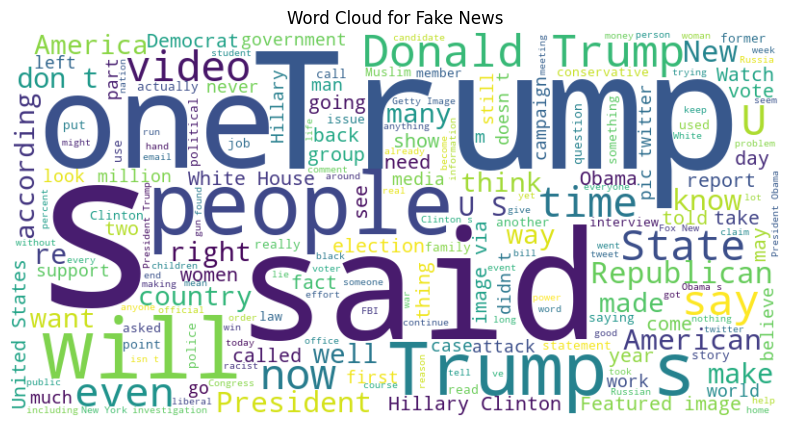

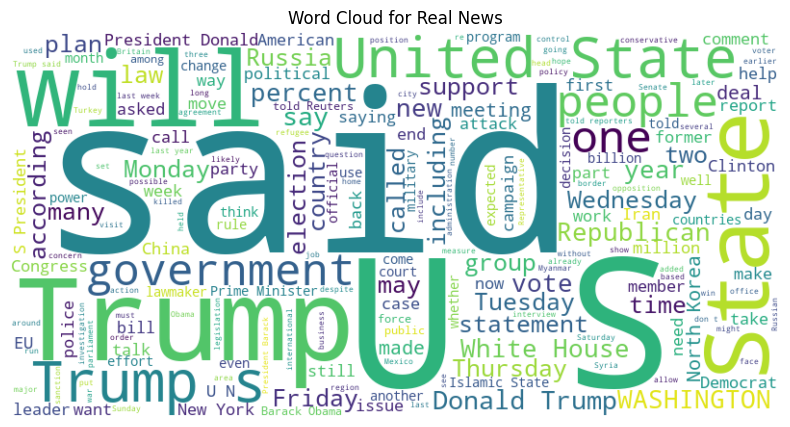

In [24]:
# Word Clouds
def generate_word_cloud(data, label_column, text_column, target_label):
    filtered_text = " ".join(data[data[label_column] == target_label][text_column])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {"Fake" if target_label == 0 else "Real"} News')
    plt.show()

# Generate Word Clouds
generate_word_cloud(test_data, 'label', 'content', target_label=0)  # Fake News
generate_word_cloud(test_data, 'label', 'content', target_label=1)  # Real News

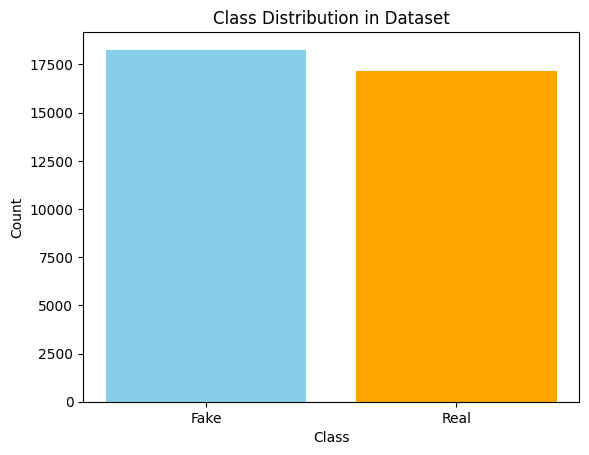

In [25]:
# Class Distribution

def plot_class_distribution(data, label_column, class_names):
    class_counts = data[label_column].value_counts()
    plt.bar(class_names, class_counts, color=['skyblue', 'orange'])
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution in Dataset')
    plt.show()

plot_class_distribution(train_data, 'label', ['Fake', 'Real'])

In [26]:
from sklearn.metrics import accuracy_score, classification_report

# Calculate Accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 99.95%


In [35]:
# Classification Report
class_names = ['Fake', 'Real']
report = classification_report(true_labels, predictions, target_names=class_names)
print(report)

              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      2265
        Real       1.00      1.00      1.00      2162

    accuracy                           1.00      4427
   macro avg       1.00      1.00      1.00      4427
weighted avg       1.00      1.00      1.00      4427

